<a href="https://colab.research.google.com/github/Ea0011/florence-exploration/blob/main/florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize and load model

In [12]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [153]:
model_id = 'microsoft/Florence-2-large'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype='auto'
  ).eval().to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model

# Exploring Positional Encodings and Positional Prompts

In [154]:
processor.tokenizer("<loc_0>", add_special_tokens=False),  processor.tokenizer("<loc_999>", add_special_tokens=False) # location tokens range from 50269 to 51268

({'input_ids': [50269], 'attention_mask': [1]},
 {'input_ids': [51268], 'attention_mask': [1]})

In [155]:
token_embedding_enc = model.language_model.model.encoder.embed_tokens.weight.data
token_embedding_dec = model.language_model.model.decoder.embed_tokens.weight.data

location_token_embedding_enc = token_embedding_enc[50269:51269]
location_token_embedding_dec = token_embedding_dec[50269:51269]

In [156]:
# Get positional embeddings
img_pos_emb_row = model.image_pos_embed.row_embeddings.weight.data
img_pos_emb_col = model.image_pos_embed.column_embeddings.weight.data
img_feature_proj = model.image_projection.data
image_feature_norm = model.image_proj_norm

# Create map for 50x50 square image feature
img_pos_emb_cat = torch.cat([img_pos_emb_col.unsqueeze(0).repeat(50, 1, 1), img_pos_emb_row.unsqueeze(1).repeat(1, 50, 1)], dim=-1)
# Project to language model dimension

img_pos_emb_proj = img_pos_emb_cat @ img_feature_proj
image_pos_emb_norm = image_feature_norm(img_pos_emb_proj)


In [157]:
image_pos_emb_norm.shape

torch.Size([50, 50, 1024])

In [158]:
loc_emb_similarity = location_token_embedding_enc @ location_token_embedding_dec.T # Definitely not shared

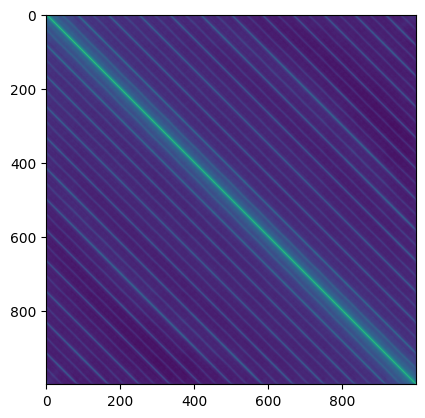

In [159]:
plt.imshow(loc_emb_similarity) # shows periodic similarity patterns

In [160]:
loc_emb_similarity.argmax(dim=1) - torch.arange(1000)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Do Location Embeddings in the Embedding Table interract with learned 2D positional embeddings


---


Compute the composition score: ||AB||_F / (||A||_F * ||B||_F) to get an idea

The location tokens do not significantly interract with the positional embeddings in the encoder.  

The decoder positional embedding and location tokens do interract with each other.  

In [162]:
# How do location tokens align with positional embeddings in the model?
img_pos = image_pos_emb_norm[11, :5].reshape(-1, 1024)
(img_pos @ location_token_embedding_enc.T).norm(p="fro") / (img_pos.norm(p="fro") * location_token_embedding_enc.norm(p="fro"))

tensor(0.0311, dtype=torch.float16, grad_fn=<DivBackward0>)

In [116]:
(img_pos @ location_token_embedding_dec.T).norm(p="fro") / (img_pos.norm(p="fro") * location_token_embedding_dec.norm(p="fro"))

tensor(0.0375, dtype=torch.float16, grad_fn=<DivBackward0>)

In [117]:
(img_pos @ location_token_embedding_dec.T).norm(p="fro") / (img_pos.norm(p="fro") * location_token_embedding_dec.norm(p="fro"))

tensor(0.0375, dtype=torch.float16, grad_fn=<DivBackward0>)

In [118]:
(img_pos @ location_token_embedding_enc.T).norm(p="fro") / (img_pos.norm(p="fro") * location_token_embedding_enc.norm(p="fro"))

tensor(0.0375, dtype=torch.float16, grad_fn=<DivBackward0>)

In [87]:
# Composition score for random matrices of the same size
scores = []

for i in range(100):
  A = torch.randn_like(img_pos) * (0.0002) ** 0.5
  B = torch.randn_like(location_token_embedding_enc) * (0.0002) ** 0.5
  scores.append((A @ B.T).norm(p="fro") / (A.norm(p="fro") * B.norm(p="fro")))

(array([ 2.,  2.,  2., 11., 17., 20., 25., 10.,  7.,  4.]),
 array([0.03494263, 0.03515625, 0.03533936, 0.03555298, 0.03573608,
        0.03594971, 0.03616333, 0.03634644, 0.03656006, 0.03674316,
        0.03695679]),
 <BarContainer object of 10 artists>)

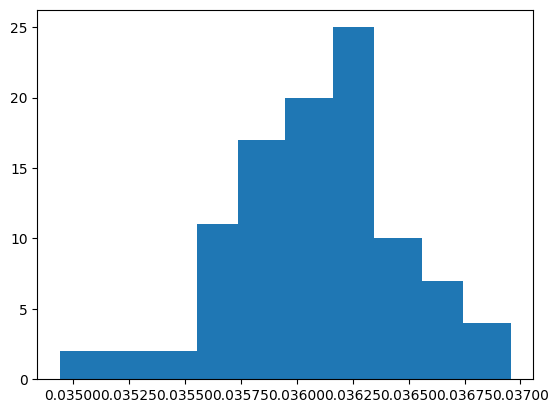

In [88]:
plt.hist(scores)

In [164]:
loc_token_img_sim = (image_pos_emb_norm @ location_token_embedding_enc.T)

In [165]:
similarity_for_tokens = []
for i in range(0, 1000):
  similarity_map = loc_token_img_sim[:, :, i].detach().cpu().numpy()
  similarity_for_tokens.append(similarity_map)

In [166]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(i):
    plt.figure(2)
    plt.imshow(similarity_for_tokens[i])
    plt.show()

interactive_plot = interactive(f, i=list(range(0, 1000)))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…